In [2]:
import torch, torchvision,cv2
import torchvision.transforms as T
from torchvision.models.detection import MaskRCNN
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO

In [3]:
# List of COCO class names
COCO_INSTANCE_CATEGORY_NAMES = ['',
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter',
    'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet',
    'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [4]:
# Load pre-trained Faster R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 108MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [12]:
# Function to get a prediction
def get_prediction(img_path,threshold):
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] #Get
  pred_boxes = [[(i[0],i[1]),(i[2],i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+2]
  return masks, pred_boxes, pred_class

In [21]:
img_path = 'cat.jpg'
masks , pred_boxes, pred_class = get_prediction(img_path,0.5)

In [22]:
pred_class

['cat', 'tv']

In [23]:
pred_boxes

[[(840.8284, 245.07404), (1602.9456, 1154.6582)]]

In [24]:
masks[0].shape

(1281, 1920)

In [25]:
img = plt.imread(img_path)

(-0.5, 1919.5, 1280.5, -0.5)

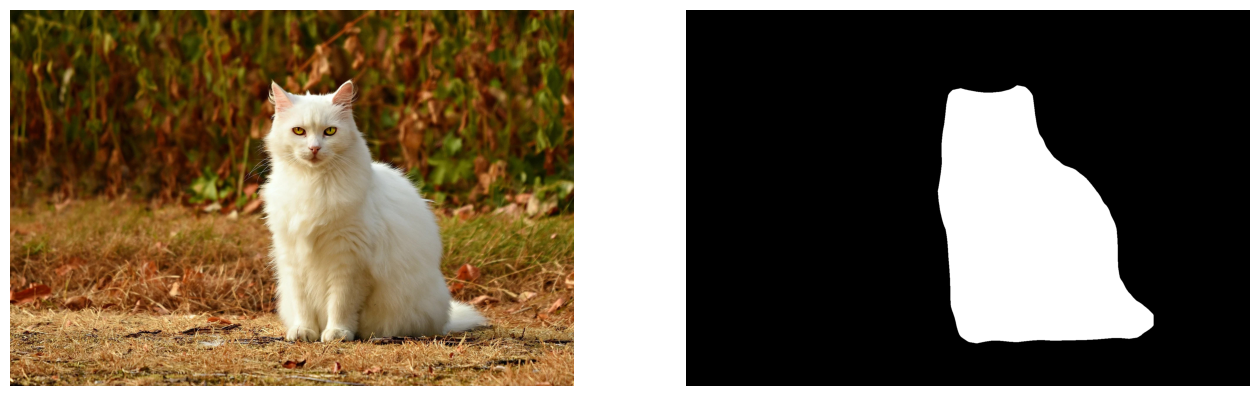

In [27]:
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.imshow(img)
plt.axis('off')
plt.subplot(122)
plt.imshow(masks[0],cmap='gray')
plt.axis('off')

In [42]:
import random
def random_colour_masks(image):
  colours = [[0,255,0],[255,0,0],[0,0,255],[0,255,255],[255,255,0],[255,0,255],[80,70,100],[250,80,190],[245,145,50],[70,150,250],[50,190,190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1] ,g[image == 1],b[image == 1] =colours[random.randrange(0,10)]
  coloured_mask = np.stack([r,g,b],axis=2)
  return coloured_mask


In [43]:
def find_mask (img_path,threshold=0.5):
  masks , boxes, pred_cls = get_prediction(img_path,threshold)
  img = plt.imread(img_path)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img,1,rgb_mask,0.5,0)
  plt.figure(figsize=(12,8))
  plt.imshow(img)
  plt.axis('off')



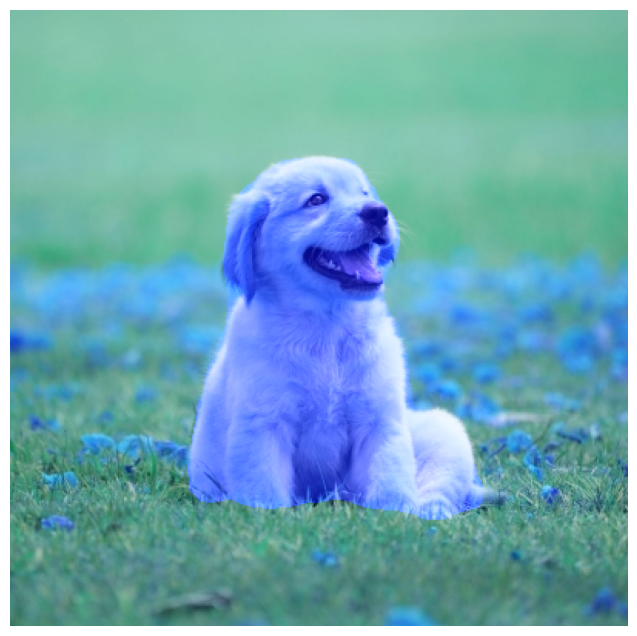

In [44]:
find_mask('dog.jpg')

In [ ]:
.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,.